# Evaluate the Model

Evaluation model with data test (use 7)

In [16]:
import yaml
import pandas as pd
import shap
import os
import joblib
import numpy as np

from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import shap
import matplotlib.pyplot as plt

In [23]:
if 'iter' in os.getcwd().split('/')[-1]:
    ######## run manually #############
    with open("../../config.yaml", "r") as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
        
    if os.name == 'posix' :
        PATH_MODEL = config['path']['artifact']+os.getcwd().split('/')[-1]+'/'
    else:
        PATH_MODEL = config['path']['artifact']+os.getcwd().split('\\')[-1]+'/'

else:
    ######### run with makefile #############
    with open("config-make.yaml", "r") as f:
        config = yaml.load(f, Loader=yaml.FullLoader)

    if os.name == 'posix' :
        PATH_MODEL = config['path']['artifact']+'iteration_2/'
    else:
        PATH_MODEL = config['path']['artifact']+'iteration_2/'

PATH_RAW = config['path']['raw']
PATH_INTERIM = config['path']['interim']
PATH_PROCESSED = config['path']['processed']
PATH_UDF = config['path']['udf']
PATH_FIG = config['path']['figure']

## Get data and Model

In [3]:
raw_data = pd.read_csv(PATH_INTERIM+'data_tes_iter2.csv')
col_cat_load = joblib.load(PATH_MODEL+'cat_names.pkl')
col_num_load = joblib.load(PATH_MODEL+'num_names.pkl')

col_num = ['age','balance','day',
                      'duration','pdays']
col_cat2 = ['marital', 'default', 'job2', 'is_contacted', 'contact', 'education']

raw_data['y2'] = (raw_data['y'] == 'yes').astype(int)

In [21]:
## preprocessing
rule_cap_load = joblib.load(PATH_MODEL+'outliers_cap_rules.pkl')
scaler_load = joblib.load(PATH_MODEL+'minmax_scaler.pkl')
oh_load = joblib.load(PATH_MODEL+'oh_encoding.pkl')

raw_data['is_contacted'] = (raw_data['pdays'] != -1).astype(int)
raw_data['balance2'] = np.where(raw_data['balance']<0,0, raw_data['balance'])

for c2 in col_num:
    if c2 == 'balance':
        ck = c2+'2'
    else:
        ck = c2
    max_cap = rule_cap_load[c2]
    raw_data[ck+'_cap'] = np.where(raw_data[ck] >= max_cap, max_cap, raw_data[ck])
    

jgroup1 = ['services', 'self-employed', 'entrepreneur', 'housemaid']
jgroup2 = ['admin.', 'technician', 'unknown']
raw_data['job2'] = raw_data['job'].apply(lambda x : np.where(x in jgroup1,'jgr1',
                                                        np.where(x in jgroup2,'jgr2',x)))


df_num = pd.DataFrame(scaler_load.transform(raw_data[col_num_load]), columns = col_num_load)
df_num['target'] = raw_data['y2'].copy()
df_cat = pd.DataFrame(oh_load.transform(
        raw_data[col_cat2]).toarray(), columns = col_cat_load)

df_interim = pd.concat([df_num,df_cat], axis = 1)

In [5]:
## Best Model
best_mdl = joblib.load(PATH_MODEL+'logreg7.pkl')

## Evaluation

In [6]:
Y_true = raw_data['y2']
1-Y_true.mean()

0.8774517032886004

In [7]:
## Summary
Xd = df_interim[col_num_load+col_cat_load]
Y_prob_pred = best_mdl.predict(Xd)
print(classification_report(Y_true,Y_prob_pred))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      5950
           1       0.42      0.63      0.51       831

    accuracy                           0.85      6781
   macro avg       0.68      0.76      0.71      6781
weighted avg       0.88      0.85      0.86      6781



In [8]:
Y_prob_pred.mean()

0.1836012387553458

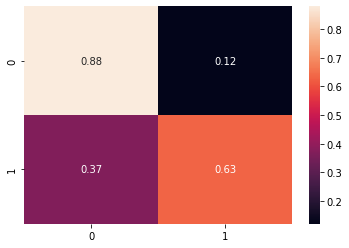

In [27]:
cm = confusion_matrix(Y_true,Y_prob_pred)
cm2 = (cm.transpose()/cm.sum(axis=1)).transpose()
fig = sns.heatmap(cm2,annot = True)
plt.savefig(PATH_FIG + 'iteration2_conf_mat.png', facecolor=fig.get_facecolor())

## Explainability

In [10]:
X_tr = joblib.load(PATH_MODEL+'train_data7.pkl')

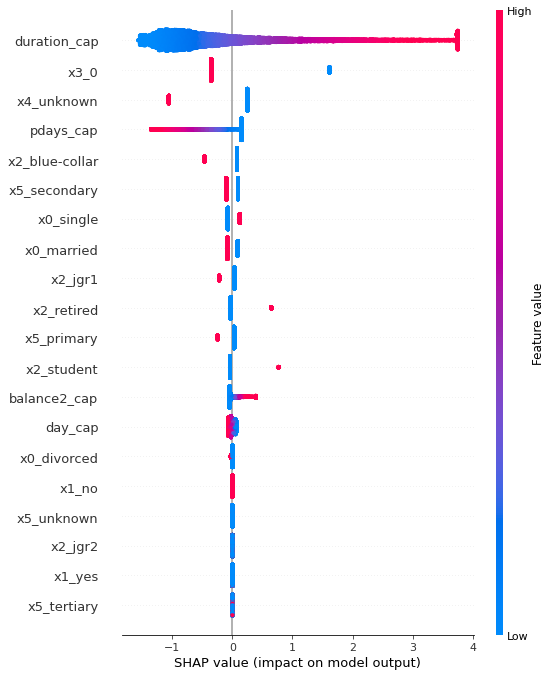

In [28]:
masker = shap.maskers.Independent(data=X_tr)
explainer = shap.LinearExplainer(best_mdl, masker = masker)
shap_values = explainer.shap_values(X_tr)
shap.summary_plot(shap_values, features=X_tr, feature_names=X_tr.columns, show=False)
plt.savefig(PATH_FIG + 'iteration2_shap.png', facecolor=fig.get_facecolor())